In [1]:
# Import necessary packages
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans

C:\Users\liux157\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Get all CBSA
df_CBSA_UrbanBEM = pd.read_csv('CBSA_UrbanBEM_06.08.2022.csv')

# Column titles
cbsa_elec_columns = ['jan_elec_eui', 'feb_elec_eui', 'mar_elec_eui', 'apr_elec_eui',
                              'may_elec_eui', 'jun_elec_eui', 'jul_elec_eui', 'aug_elec_eui',
                              'sep_elec_eui', 'oct_elec_eui', 'nov_elec_eui', 'dec_elec_eui']
cbsa_gas_columns = ['jan_gas_eui', 'feb_gas_eui', 'mar_gas_eui', 'apr_gas_eui',
                              'may_gas_eui', 'jun_gas_eui', 'jul_gas_eui', 'aug_gas_eui',
                              'sep_gas_eui', 'oct_gas_eui', 'nov_gas_eui', 'dec_gas_eui']
urbanbem_elec_columns = ['Jan_Electricity_EUI', 'Feb_Electricity_EUI', 'Mar_Electricity_EUI', 'Apr_Electricity_EUI',
                              'May_Electricity_EUI', 'Jun_Electricity_EUI', 'Jul_Electricity_EUI', 'Aug_Electricity_EUI',
                              'Sep_Electricity_EUI', 'Oct_Electricity_EUI', 'Nov_Electricity_EUI', 'Dec_Electricity_EUI']
urbanbem_gas_columns = ['Jan_Gas_EUI', 'Feb_Gas_EUI', 'Mar_Gas_EUI', 'Apr_Gas_EUI',
                              'May_Gas_EUI', 'Jun_Gas_EUI', 'Jul_Gas_EUI', 'Aug_Gas_EUI',
                              'Sep_Gas_EUI', 'Oct_Gas_EUI', 'Nov_Gas_EUI', 'Dec_Gas_EUI']

# Gas/Electricity EUI data from CBSA and UrbanBEM
df_cbsa_elec = df_CBSA_UrbanBEM[cbsa_elec_columns]
df_urbanbem_elec = df_CBSA_UrbanBEM[urbanbem_elec_columns]
df_cbsa_gas = df_CBSA_UrbanBEM[cbsa_gas_columns]
df_urbanbem_gas = df_CBSA_UrbanBEM[urbanbem_gas_columns]

# Differences
elec_diff = df_cbsa_elec.values - df_urbanbem_elec.values
gas_diff = df_cbsa_gas.values - df_urbanbem_gas.values

# Normalize to unit vectors
elec_diff_norm = np.ndarray([len(elec_diff), 12])
gas_diff_norm = np.ndarray([len(gas_diff), 12])

for i in range(len(elec_diff)):
    elec_diff_norm[i, :] = elec_diff[i, :]/np.linalg.norm(elec_diff[i, :])
    gas_diff_norm[i, :] = gas_diff[i, :]/np.linalg.norm(gas_diff[i, :])

gas_diff_norm[np.isnan(gas_diff_norm)] = 0

Text(0.5, 1.0, 'EUI differences-Gas')

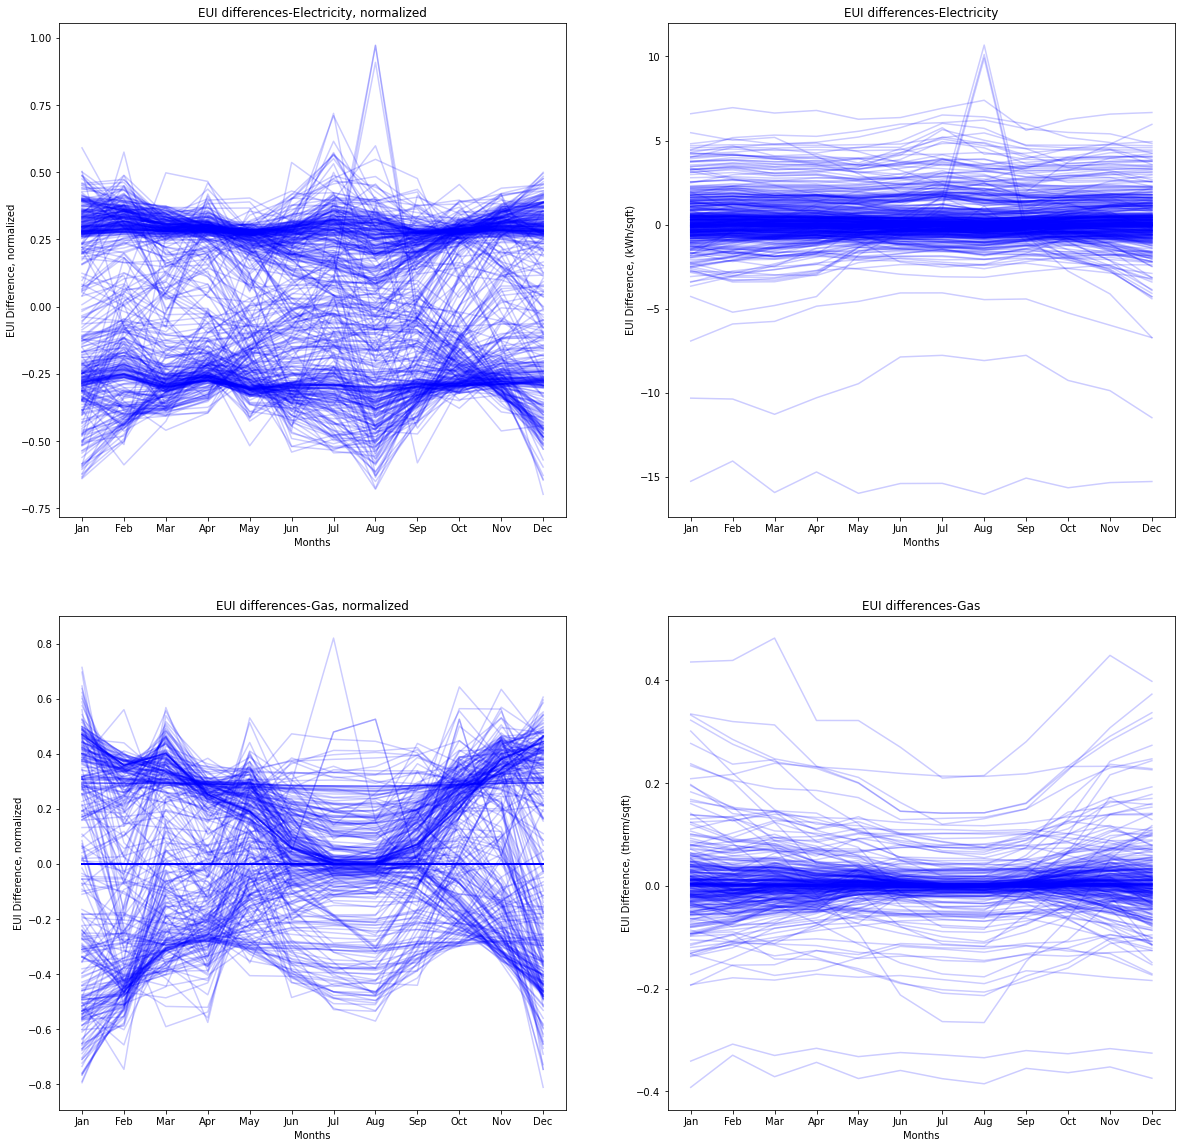

In [3]:
# Plot before/after normalization
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20,20))

axes[0, 0].plot(months, elec_diff_norm.T, color = 'blue', alpha = 0.2, label = 'Raw data normalized')
axes[0, 1].plot(months, elec_diff.T, color = 'blue', alpha = 0.2, label = 'Raw data')
axes[1, 0].plot(months, gas_diff_norm.T, color = 'blue', alpha = 0.2, label = 'Raw data normalized')
axes[1, 1].plot(months, gas_diff.T, color = 'blue', alpha = 0.2, label = 'Raw data')

axes[0, 0].set_ylabel('EUI Difference, normalized')
axes[0, 1].set_ylabel('EUI Difference, (kWh/sqft)')
axes[1, 0].set_ylabel('EUI Difference, normalized')
axes[1, 1].set_ylabel('EUI Difference, (therm/sqft)')

axes[0, 0].set_xlabel('Months')
axes[0, 1].set_xlabel('Months')
axes[1, 0].set_xlabel('Months')
axes[1, 1].set_xlabel('Months')

axes[0, 0].set_title('EUI differences-Electricity, normalized')
axes[0, 1].set_title('EUI differences-Electricity')
axes[1, 0].set_title('EUI differences-Gas, normalized')
axes[1, 1].set_title('EUI differences-Gas')

In [4]:
def k_means_eval(n_cluster, center, data):

# n_cluster: number of clusters
# center: center vectors of each cluster from kmeans output
# data: data sent for kmeans clustering in df after adding labels
    
    err_sum =  np.zeros(12)
    for n in range(n_cluster):
        clustered_val = data[data['label'] == n][months].values
        err = clustered_val - center[n]
        err_sum += np.sqrt(np.sum(err**2, axis = 0)/clustered_val.shape[0])
    # return MSE
    return(np.mean(err_sum/n_cluster))

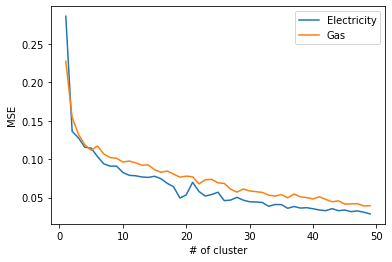

In [5]:
# number of cluster vs training error
MSE_elec_all = []
MSE_gas_all = []
total_cluster = 50
for i in np.arange(1, total_cluster):
    n_elec = i
    n_gas = i
    Kmean_elec = KMeans(n_clusters = n_elec)
    Kmean_gas = KMeans(n_clusters = n_gas)
    Kmean_elec.fit(elec_diff_norm)
    Kmean_gas.fit(gas_diff_norm)
    center_elec = Kmean_elec.cluster_centers_
    center_gas = Kmean_gas.cluster_centers_
    label_elec = Kmean_elec.labels_
    label_gas = Kmean_gas.labels_
    
    df_elec_diff_norm = pd.DataFrame(elec_diff_norm, columns = months)
    df_elec_diff_norm['label'] = label_elec
    df_gas_diff_norm = pd.DataFrame(gas_diff_norm, columns = months)
    df_gas_diff_norm['label'] = label_gas
    
    MSE_elec = k_means_eval(n_elec, center_elec, df_elec_diff_norm)
    MSE_gas = k_means_eval(n_gas, center_gas, df_gas_diff_norm)
    
    MSE_elec_all.append(MSE_elec)
    MSE_gas_all.append(MSE_gas)
    

plt.plot(np.arange(1, total_cluster), MSE_elec_all, label = 'Electricity')
plt.plot(np.arange(1, total_cluster), MSE_gas_all, label = 'Gas')
plt.ylabel('MSE')
plt.xlabel('# of cluster')
plt.legend(loc = 'best')

In [28]:
# Finalize # of cluster and train
n_elec = 6
n_gas = 6
Kmean_elec = KMeans(n_clusters = n_elec)
Kmean_gas = KMeans(n_clusters = n_gas)
Kmean_elec.fit(elec_diff_norm)
Kmean_gas.fit(gas_diff_norm)
center_elec = Kmean_elec.cluster_centers_
center_gas = Kmean_gas.cluster_centers_
label_elec = Kmean_elec.labels_
label_gas = Kmean_gas.labels_

In [29]:
df_elec_diff_norm = pd.DataFrame(elec_diff_norm, columns = months)
df_elec_diff_norm['label'] = label_elec
df_elec_diff_norm['facility_id'] = df_CBSA_UrbanBEM['facility_id']
df_gas_diff_norm = pd.DataFrame(gas_diff_norm, columns = months)
df_gas_diff_norm['label'] = label_gas
df_gas_diff_norm['facility_id'] = df_CBSA_UrbanBEM['facility_id']

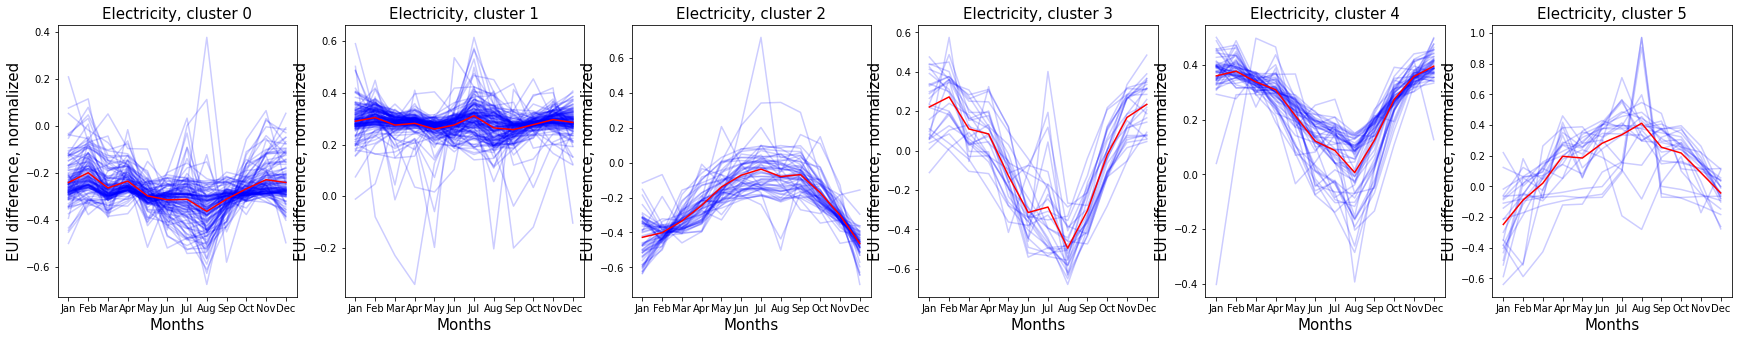

In [30]:
fig, axes = plt.subplots(nrows = 1, ncols = n_elec, figsize = (30,5))
for n in range(n_elec):
    
    elec_clustered = df_elec_diff_norm[df_elec_diff_norm['label'] == n][months].values
    index = df_elec_diff_norm[df_elec_diff_norm['label'] == n]['facility_id'].values
    axes[n].plot(months, elec_clustered.T, color = 'blue', alpha = 0.2, label = 'Raw data normalized')
    axes[n].plot(months, center_elec[n], color = 'red', label = 'Cluster center')
    
    axes[n].set_ylabel('EUI difference, normalized', fontsize=15)
    axes[n].set_xlabel('Months', fontsize=15)
    axes[n].set_title('Electricity, cluster ' + str(n) , fontsize=15)

plt.savefig('electricity_cluster.jpeg', dpi=300)

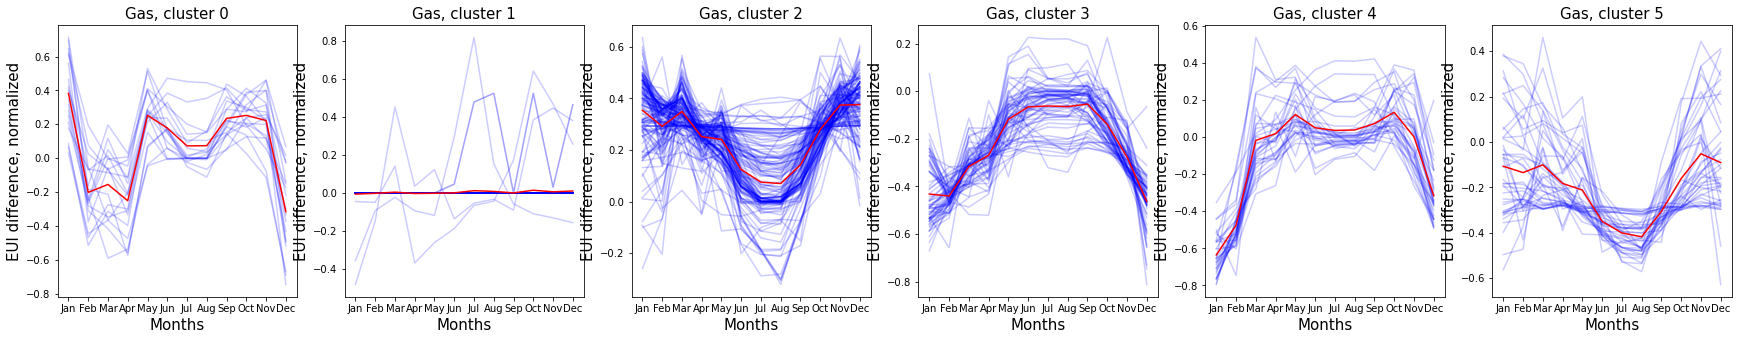

In [31]:
    
fig, axes = plt.subplots(nrows = 1, ncols = n_gas, figsize = (30,5))
for n in range(n_gas):
    
    gas_clustered = df_gas_diff_norm[df_gas_diff_norm['label'] == n][months].values
    axes[n].plot(months, gas_clustered.T, color = 'blue', alpha = 0.2, label = 'Raw data normalized')
    axes[n].plot(months, center_gas[n], color = 'red', label = 'Cluster center')
    
    axes[n].set_ylabel('EUI difference, normalized', fontsize=15)
    axes[n].set_xlabel('Months', fontsize=15)
    axes[n].set_title('Gas, cluster ' + str(n), fontsize=15)

plt.savefig('gas_cluster.jpeg', dpi=300)

In [32]:
df_elec_diff = pd.DataFrame(elec_diff, columns = months)
df_elec_diff['label'] = label_elec
df_elec_diff['facility_id'] = df_CBSA_UrbanBEM['facility_id']

df_gas_diff= pd.DataFrame(gas_diff, columns = months)
df_gas_diff['label'] = label_gas
df_gas_diff['facility_id'] = df_CBSA_UrbanBEM['facility_id']

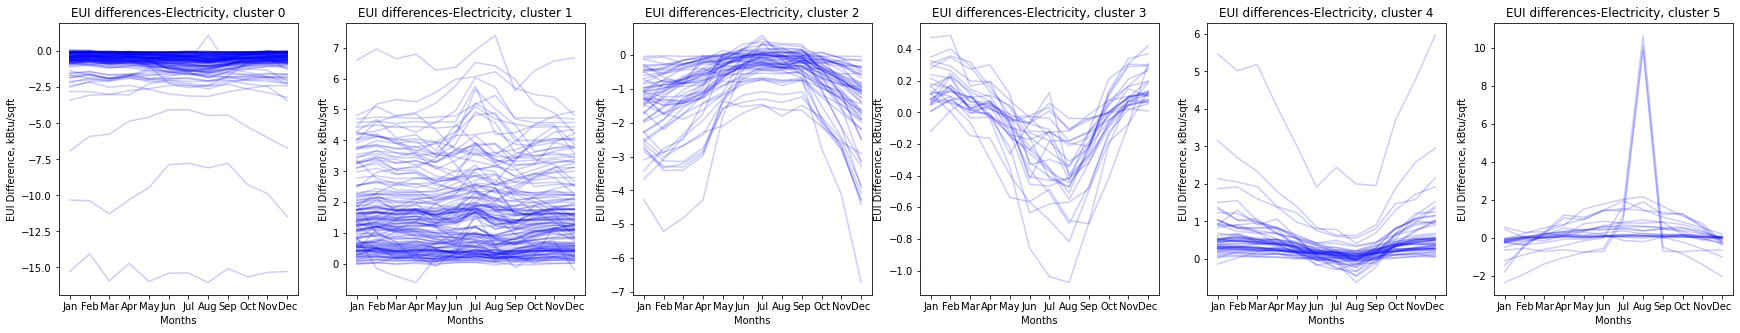

In [33]:
fig, axes = plt.subplots(nrows = 1, ncols = n_elec, figsize = (30,5))
for n in range(n_elec):
    
    elec_clustered = df_elec_diff[df_elec_diff['label'] == n][months].values
    axes[n].plot(months, elec_clustered.T, color = 'blue', alpha = 0.2, label = 'Raw data')
    
    axes[n].set_ylabel('EUI Difference, kBtu/sqft')
    axes[n].set_xlabel('Months')
    axes[n].set_title('EUI differences-Electricity, cluster ' + str(n))

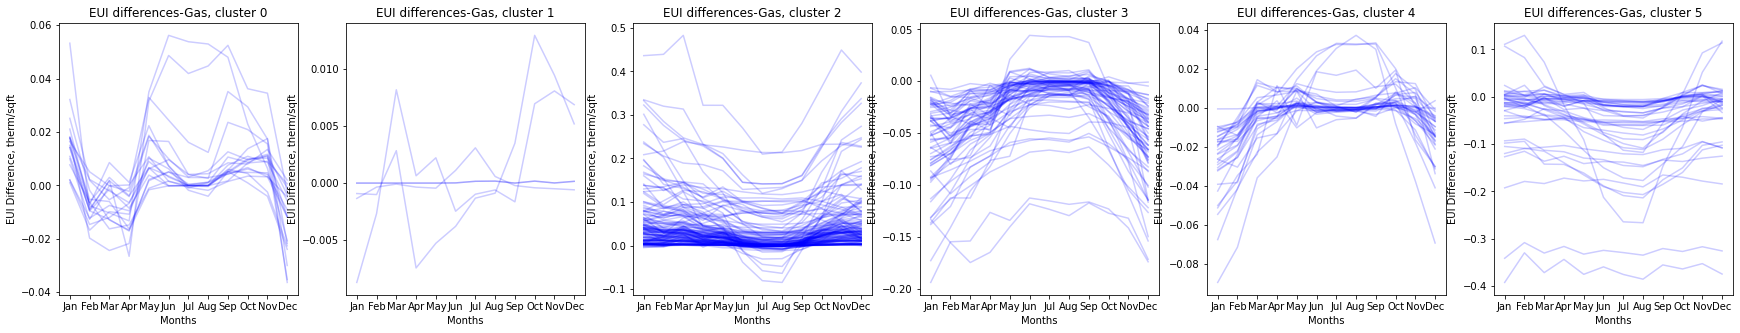

In [34]:
fig, axes = plt.subplots(nrows = 1, ncols = n_gas, figsize = (30,5))
for n in range(n_gas):
    
    gas_clustered = df_gas_diff[df_gas_diff['label'] == n][months].values
    axes[n].plot(months, gas_clustered.T, color = 'blue', alpha = 0.2, label = 'Raw data')
    
    axes[n].set_ylabel('EUI Difference, therm/sqft')
    axes[n].set_xlabel('Months')
    axes[n].set_title('EUI differences-Gas, cluster ' + str(n))

In [13]:
for facility in df_CBSA_UrbanBEM['facility_id']:
    elec_label = df_elec_diff[df_elec_diff['facility_id'] == facility]['label'].values[0]
    gas_label = df_gas_diff[df_gas_diff['facility_id'] == facility]['label'].values[0]
    #print(elec_label, gas_label)
    
    cbsa_elec_data = df_CBSA_UrbanBEM.loc[df_CBSA_UrbanBEM['facility_id'] == facility, cbsa_elec_columns]
    urbanbem_elec_data = df_CBSA_UrbanBEM.loc[df_CBSA_UrbanBEM['facility_id'] == facility, urbanbem_elec_columns]
    cbsa_gas_data = df_CBSA_UrbanBEM.loc[df_CBSA_UrbanBEM['facility_id'] == facility, cbsa_gas_columns]
    urbanbem_gas_data = df_CBSA_UrbanBEM.loc[df_CBSA_UrbanBEM['facility_id'] == facility, urbanbem_gas_columns]


    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))

    axes[0].plot(months, cbsa_elec_data.values[0], 'r', label = 'CBSA')
    axes[0].plot(months, urbanbem_elec_data.values[0], 'b', label = 'UrbanBEM')
    axes[1].plot(months, cbsa_gas_data.values[0], 'r', label = 'CBSA')
    axes[1].plot(months, urbanbem_gas_data.values[0], 'b', label = 'UrbanBEM')
    axes[0].set_ylabel('EUI (kWh/sqft)')
    axes[1].set_ylabel('EUI (therm/sqft)')
    #axes[0].set_ylim(-2, 6)
    #axes[1].set_ylim(-0.2, 0.3)
    axes[0].set_title(str(facility) + ' Electricity')
    axes[1].set_title(str(facility) + ' Gas')
    axes[0].legend()
    axes[1].legend()
    fig.savefig('./figs/06.08.2022/elec/'+str(elec_label)+'/'+str(facility))
    fig.savefig('./figs/06.08.2022/gas/'+str(gas_label)+'/'+str(facility))
    plt.close()

In [ ]:
for n in range(n_elec):
    elec_clustered = df_elec_diff[df_elec_diff['label'] == n][months].values
    index = df_elec_diff[df_elec_diff['label'] == n]['facility_id'].values
    for idx in range(len(index)):
        fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5))
        elec = elec_clustered[idx, :]
        axes.plot(months, elec, color = 'blue', alpha = 0.2, label = 'Raw data')
        axes.set_ylabel('EUI Difference, kBtu/sqft')
        axes.set_xlabel('Months')
        axes.set_title('EUI differences-Electricity, cluster ' + str(n) + ', building '+ str(index[idx]))
        plt.savefig('figs/elec/'+str(n)+'/'+str(index[idx])+'.jpeg', dpi=300)

In [ ]:
for n in range(n_gas):
    gas_clustered = df_gas_diff[df_gas_diff['label'] == n][months].values
    index = df_gas_diff[df_gas_diff['label'] == n]['facility_id'].values
    for idx in range(len(index)):
        fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5))
        gas = gas_clustered[idx, :]
        axes.plot(months, gas, color = 'blue', alpha = 0.2, label = 'Raw data')
        axes.set_ylabel('EUI Difference, kBtu/sqft')
        axes.set_xlabel('Months')
        axes.set_title('EUI differences-Gas, cluster ' + str(n) + ', building '+ str(index[idx]))
        plt.savefig('figs/gas/'+str(n)+'/'+str(index[idx])+'.jpeg', dpi=300)

In [ ]:
df_elec_diff.to_csv('electricity_diff_labeled_06.08.2022.csv')
df_gas_diff.to_csv('gas_diff_labeled_06.08.2022.csv')

In [ ]:
buildings = [5897, 7381, 7645, 8315] # misclassified HVAC
# 5897: PSZ gas furnace -> PTAC fossil fuel boiler
# 7381: VAV_HotWater_ChilledWater -> 'VAV', 'Gas central heating and electric reheat', 'Direct expansion'
# 7645: VAV_HotWater_ChilledWater -> 'VAV', 'Gas central heating and electric reheat', 'Direct expansion'
# 8315: VAV_HotWater_ChilledWater -> 'Packaged terminal air conditioner', 'Constant volume', 'Hot-water fossil fuel boiler', 'Direct expansion

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12,5))

for building in buildings:
    axes[0].plot(months, df_elec_diff[df_elec_diff['facility_id'] == building][months].values[0], label = building)
    axes[1].plot(months, df_gas_diff[df_gas_diff['facility_id'] == building][months].values[0], label = building)

axes[0].set_ylabel('EUI (kWh/sqft)')
axes[1].set_ylabel('EUI (therm/sqft)')
axes[0].set_title('Electricity')
axes[1].set_title('Gas')
axes[0].legend()
axes[1].legend()